# Setup

## Imports

In [57]:
import pandas as pd
import numpy as np
import os
import dotenv
import matplotlib.pyplot as plt
import boto3
import sagemaker

from sklearn.metrics import mean_absolute_error, mean_squared_error

## Variaveis de ambiente

In [25]:
dotenv.load_dotenv()
role = os.getenv("ROLE")

if not role:
    raise ValueError("ROLE environment variable not set. Please set it to the name of the role you want to run.")

## Carregando os dados

In [16]:
if not os.path.exists("credit_card_clients.csv"):
    exit("Please download the dataset from https://drive.google.com/file/d/1DJo1yzOHbCzYgftPNB0SuBscC4icgmG3/view?usp=sharing and place it in the current directory.")

df = pd.read_csv("credit_card_clients.csv", header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Tratamento de dados

In [9]:
# Somar valores de PAY_AMT1	PAY_AMT2	PAY_AMT3	PAY_AMT4 .. PAY_AMT6
new = df.assign(PAY_TOTAL=df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1))
new = new.drop(columns=['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])
new.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,default payment next month,PAY_TOTAL
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,1,689
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,1,5000
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,0,11018
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,0,8388
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,0,59049


In [10]:
# Somar valores de BILL_AMT1	BILL_AMT2	BILL_AMT3	BILL_AMT4	BILL_AMT5	BILL_AMT6
new = new.assign(BILL_TOTAL=new[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1))
new = new.drop(columns=['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])
new.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default payment next month,PAY_TOTAL,BILL_TOTAL
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,1,689,7704
1,2,120000,2,2,2,26,-1,2,0,0,0,2,1,5000,17077
2,3,90000,2,2,2,34,0,0,0,0,0,0,0,11018,101653
3,4,50000,2,2,1,37,0,0,0,0,0,0,0,8388,231334
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,0,59049,109339


In [12]:
# Mantenha do dataframe somente as duas novas colunas, a idade (atributo age) e o LIMIT_BAL
new = new[['LIMIT_BAL', 'AGE', 'PAY_TOTAL', 'BILL_TOTAL']]
new.head()

,LIMIT_BAL,AGE,PAY_TOTAL,BILL_TOTAL
0,20000,24,689,7704
1,120000,26,5000,17077
2,90000,34,11018,101653
3,50000,37,8388,231334
4,50000,57,59049,109339


## Subindo os dados para o treinamento

In [13]:
data_train = new.sample(frac=0.8, random_state=1)
data_test = new.drop(data_train.index)

In [14]:
data_train.to_csv('credit_card_clients_train.csv', index=False, header=False)
data_test.to_csv('credit_card_clients_test.csv', index=False, header=False)

In [19]:
session = sagemaker.Session()
bucket = session.default_bucket()
bucket_instance = boto3.resource('s3').Bucket(bucket)
bucket_instance.name

'sagemaker-us-east-1-022499002098'

In [20]:
path_bucket_database = "datasets/credit_card_clients/xgboost/"
path_bucket_model = "models/credit_card_clients/xgboost/"

key_train = 'credit_card_clients_train'
key_test = 'credit_card_clients_test'

path_local_train = 'credit_card_clients_train.csv'
path_local_test = 'credit_card_clients_test.csv'


In [21]:
with open(path_local_train, "rb") as f:
    bucket_instance.upload_fileobj(f, path_bucket_database + key_train)

with open(path_local_test, "rb") as f:
    bucket_instance.upload_fileobj(f, path_bucket_database + key_test)

In [27]:
container = sagemaker.image_uris.retrieve(
    region=session.boto_region_name,
    framework="xgboost",
    version="1.0-1",
)

xgboost = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    output_path=f"s3://{bucket}/{path_bucket_model}",
    sagemaker_session=session,
)

xgboost.set_hyperparameters(num_round=100)

In [28]:
training_input = f"s3://{bucket}/{path_bucket_database}{key_train}"
validation_input = f"s3://{bucket}/{path_bucket_database}{key_test}"

train_input = sagemaker.inputs.TrainingInput(
    s3_data=training_input,
    distribution="FullyReplicated",
    content_type="csv",
    input_mode="File",
)

validation_input = sagemaker.inputs.TrainingInput(
    s3_data=validation_input,
    distribution="FullyReplicated",
    content_type="csv",
    input_mode="File",
)

In [29]:
xgboost.fit({"train": train_input, "validation": validation_input})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-05-14-23-32-35-538


2025-05-14 23:32:36 Starting - Starting the training job...
2025-05-14 23:33:00 Starting - Preparing the instances for training...
2025-05-14 23:33:36 Downloading - Downloading the training image...
2025-05-14 23:34:12 Training - Training image download completed. Training in progress...[2025-05-14 23:34:34.356 ip-10-0-194-216.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[23:34:34] 24000x3 matrix with 72000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[23:3

In [37]:
xgboost_regressor = xgboost.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name="credit-card-clients-xgboost",
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-05-14-23-44-20-220
INFO:sagemaker:Creating endpoint-config with name credit-card-clients-xgboost
INFO:sagemaker:Creating endpoint with name credit-card-clients-xgboost


---------!

In [39]:
xgboost_regressor.serializer = sagemaker.serializers.CSVSerializer()
xgboost_regressor.deserializer = sagemaker.deserializers.CSVDeserializer()

In [42]:
x_data_test = data_test[['AGE', 'PAY_TOTAL', 'BILL_TOTAL']].values
y_data_test = data_test[['LIMIT_BAL']].values

In [48]:
y_predict = xgboost_regressor.predict(x_data_test)
y_predict_np = np.array(y_predict).reshape(-1, 1).astype(np.float32)
y_predict_np

array([[138833.5 ],
       [ 67288.71],
       [238626.58],
       ...,
       [246105.06],
       [208166.2 ],
       [ 75507.55]], dtype=float32)

In [47]:
y_data_test_np = np.array(y_data_test).reshape(-1, 1).astype(np.float32)
y_data_test_np

array([[250000.],
       [ 50000.],
       [360000.],
       ...,
       [150000.],
       [ 30000.],
       [ 50000.]], dtype=float32)

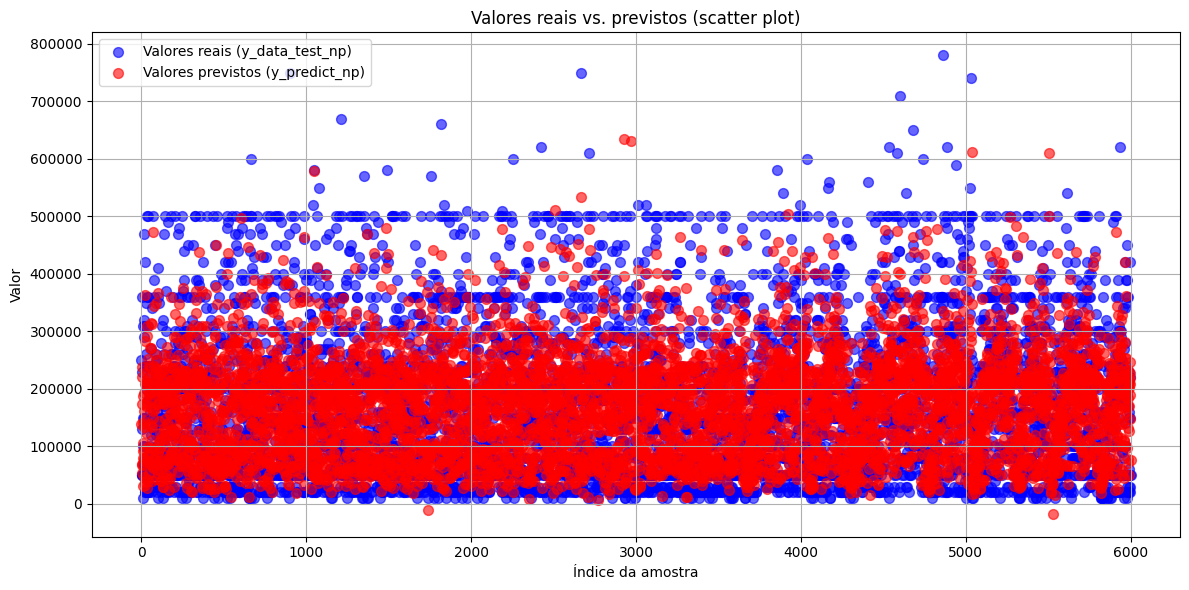

In [51]:
indices = np.arange(len(y_data_test_np))
plt.figure(figsize=(12, 6))

plt.scatter(indices, y_data_test_np, color='blue', label='Valores reais (y_data_test_np)', alpha=0.6, s=50)
plt.scatter(indices, y_predict_np, color='red', label='Valores previstos (y_predict_np)', alpha=0.6, s=50)

plt.title('Valores reais vs. previstos (scatter plot)')
plt.xlabel('Índice da amostra')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

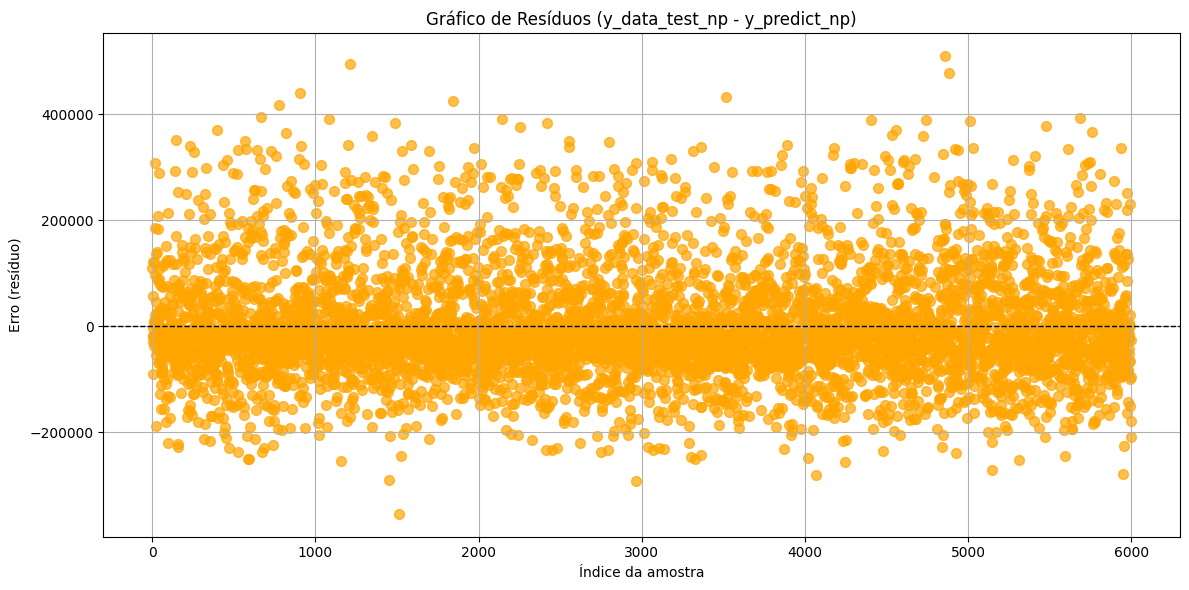

In [53]:
residuos = y_data_test_np - y_predict_np

plt.figure(figsize=(12, 6))
plt.scatter(indices, residuos, color='orange', alpha=0.7, s=50)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Gráfico de Resíduos (y_data_test_np - y_predict_np)')
plt.xlabel('Índice da amostra')
plt.ylabel('Erro (resíduo)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
mae = mean_absolute_error(y_data_test_np, y_predict_np)
mse = mean_squared_error(y_data_test_np, y_predict_np)
rmse = np.sqrt(mse)

print('RMSE = ', rmse)
print('MAE = ', mae)
print('MSE = ', mse)

RMSE =  102183.09026448554
MAE =  74322.65625
MSE =  10441383936.0
